In [1]:
import tensorflow as tf
import pickle
import gzip
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from util import *
sns.set()
sns.set_style('whitegrid')

from numpy.random import normal, poisson
from numpy.polynomial.hermite import hermval
from numpy.polynomial.laguerre import lagval
from scipy.special import genlaguerre
from scipy.stats import norm, nbinom, gamma

%matplotlib inline

## The Hermite Case - X, Y following jointly Gaussian distribution

In [2]:
n_samples = 5000
n_samples_val = 1000
batch_size = 50

p = 1
v = 1
X = normal(0, p, (n_samples, 1))
Y = normal(X, v, (n_samples, 1))

n_input = 1
n_output = 4

session = tf.InteractiveSession()

(x_input,f_output,keepX) = SimpleNet(n_input, name="Fnet", structure = [30, 30, n_output])
(y_input,g_output,keepY) = SimpleNet(n_input, name="Gnet", structure = [30, 30, n_output])

lrate = tf.placeholder_with_default(1e-2,[])
objective, _ = create_loss_svd(f_output, g_output)
step = tf.train.GradientDescentOptimizer(lrate).minimize(objective)
session.run(tf.global_variables_initializer())

In [3]:
n_epochs = 8000
obj = []
vals = []
F_vals = []
prod_vals = []
corr_vals = []
rate = 5e-3

pic_sum_val = []
X_val = normal(0, p, (n_samples_val, 1))
Y_val = normal(X_val, v, (n_samples_val, 1))

for k in tqdm(range(n_epochs)):
    session.run(step,feed_dict= {x_input:X,y_input:Y, lrate:rate})
    if k%100==0:
        obj.append(objective.eval(feed_dict= {x_input:X,y_input:Y}))
#         prod_vals.append(prodGiFG.eval(feed_dict= {x_input:X,y_input:Y}))
#        F_vals.append(f_output.eval(feed_dict= {x_input:X,y_input:Y}))
        f_train = session.run(f_output,feed_dict= {x_input:X})
        g_train = session.run(g_output,feed_dict= {y_input:Y})
        f_val, g_val = whiten(f_train, g_train, f_train, g_train)
#         temp = np.sum( np.diagonal(f_val.transpose().dot(g_val)) ) / f_val.shape[0]
#         corr_vals.append(temp)
#        vals.append(k)

#         f_val = session.run(f_output,feed_dict= {x_input:X_val})
#         g_val = session.run(g_output,feed_dict= {y_input:Y_val})
#         f_val, g_val = whiten(f_val, g_val, f_train, g_train)
        temp = objective.eval(feed_dict= {x_input:X_val,y_input:Y_val})
        pic_sum_val.append(temp)

        vals.append(k)
#         print(k, temp)
#         if temp > pic_sum_val:
#             pic_sum_val = temp
#         else:
#             break

100%|██████████| 8000/8000 [02:20<00:00, 56.80it/s]


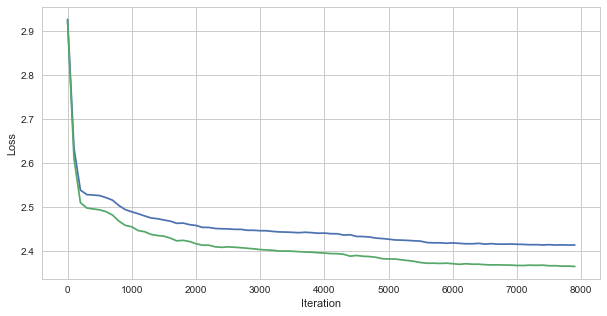

In [4]:
plt.figure(figsize=(10, 5))
# plt.plot(vals,n_output+1+np.array(obj))
plt.plot(vals,n_output+np.array(pic_sum_val))
#plt.plot(vals,np.array(corr_vals))
plt.plot(vals,n_output+np.array(obj))
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [5]:
vmin = 3
vmax = 3
n_samples = 1000
X_ = np.linspace(norm.ppf(0.01, 0, p), norm.ppf(0.99, 0, p), n_samples).reshape((n_samples, 1))
Y_ = np.linspace(norm.ppf(0.01, 0, p+v), norm.ppf(0.99, 0, p+v), n_samples).reshape((n_samples, 1))
hermite_X_out = session.run(f_output,feed_dict= {x_input:X_})
hermite_Y_out = session.run(g_output,feed_dict= {y_input:Y_})
f_train = session.run(f_output,feed_dict= {x_input:X})
g_train = session.run(g_output,feed_dict= {y_input:Y})
hermite_X, hermite_Y = whiten(hermite_X_out, hermite_Y_out, f_train, g_train)

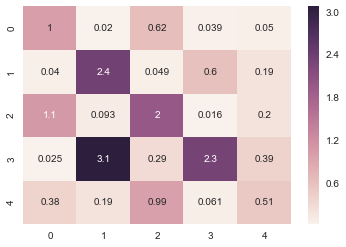

In [6]:
corrF = hermite_X.transpose().dot(hermite_X)/hermite_X.shape[0]
corrG = hermite_Y.transpose().dot(hermite_Y)/hermite_Y.shape[0]
corrFG = hermite_Y.transpose().dot(hermite_X)/hermite_Y.shape[0]


sns.heatmap(np.abs(corrFG), annot=True)

In [7]:
# def generalized_hermite(x, d, a):
#     c = np.zeros((d+1, 1))
#     c[d] = 1
#     return (a/2)**(d/2)*hermval(x/np.sqrt(2*a), c)

def generalized_hermite(x,d,a):
    x = x / np.sqrt(a)
    if d==0:
        return np.ones(len(x))
    elif d==1:
        return x
    elif d==2:
        return (x**2-1)/np.sqrt(np.math.factorial(2))
    elif d==3:
        return (x**3-3*x)/np.sqrt(np.math.factorial(3))
    elif d==4:
        return ((x**4)-6*(x**2)+3)/np.sqrt(np.math.factorial(4))

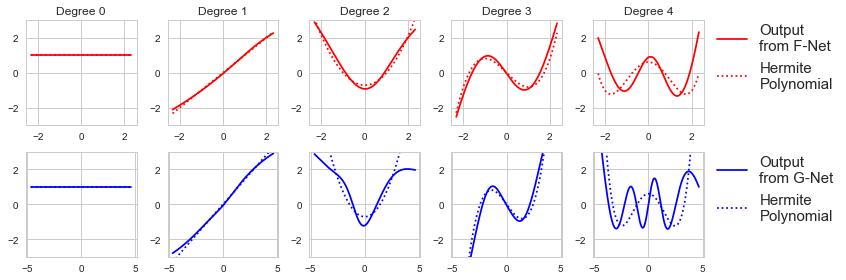

In [28]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray', 'coral', 'olive']
fs = 15
inverse_list = [0, 2, 4]

for i in range(0, hermite_X.shape[1]):
    if i in inverse_list:
        ax[0, i].plot(X_, -hermite_X[:, i], label='Output\nfrom F-Net', color='r')
        ax[1, i].plot(Y_, -hermite_Y[:, i], label='Output\nfrom G-Net', color='b')
    else:
        ax[0, i].plot(X_, hermite_X[:, i], label='Output\nfrom F-Net', color='r')
        ax[1, i].plot(Y_, hermite_Y[:, i], label='Output\nfrom G-Net', color='b')
    ax[0, i].plot(X_, generalized_hermite(X_, i, p).reshape((hermite_X.shape[0], 1)), ':', label='Hermite\nPolynomial', color='r')
    ax[0, i].set_ylim(-3, 3)
    ax[0, i].set_title('Degree '+str(i))

    ax[1, i].plot(Y_, generalized_hermite(Y_, i, p+v).reshape((hermite_Y.shape[0], 1)), ':', label='Hermite\nPolynomial', color='b')
    ax[1, i].set_ylim(-3, 3)
ax[0, 4].legend(loc='best', bbox_to_anchor=(1, 1.1), fontsize=fs)
ax[1, 4].legend(loc='best', bbox_to_anchor=(1, 1.1), fontsize=fs)
plt.tight_layout()
fig.savefig('hermite14.eps', format='eps', dpi=1000, bbox_inches='tight')